# Comparing the Efficacy of the Exemplar and Prototype Models for Predicting Color Categorization Across Languages

COG260 Research Project 2023

Gabriel Guralnick and Elizabeth Li

## Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [1]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [2]:
import numpy as np
from scipy import stats
from random import random
from collections import defaultdict, Counter
%matplotlib inline

### Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [3]:
munsellInfo = readChipData('./WCS_data_core/chip.txt')
#munsellInfo

#### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [4]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [5]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [6]:
# print(indexCoord)

#### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [7]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [8]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [9]:
# print(coordIndex)

### Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [10]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [11]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


### Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [12]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [13]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [14]:
len(namingData[1])

25

### Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [15]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [16]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

### Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [17]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [18]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [19]:
# speakerInfo[1][1]

### Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [20]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [21]:
terms = lg61_spk5.values()
# terms

Encode the color terms into random numbers (for plotting purposes).

In [22]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

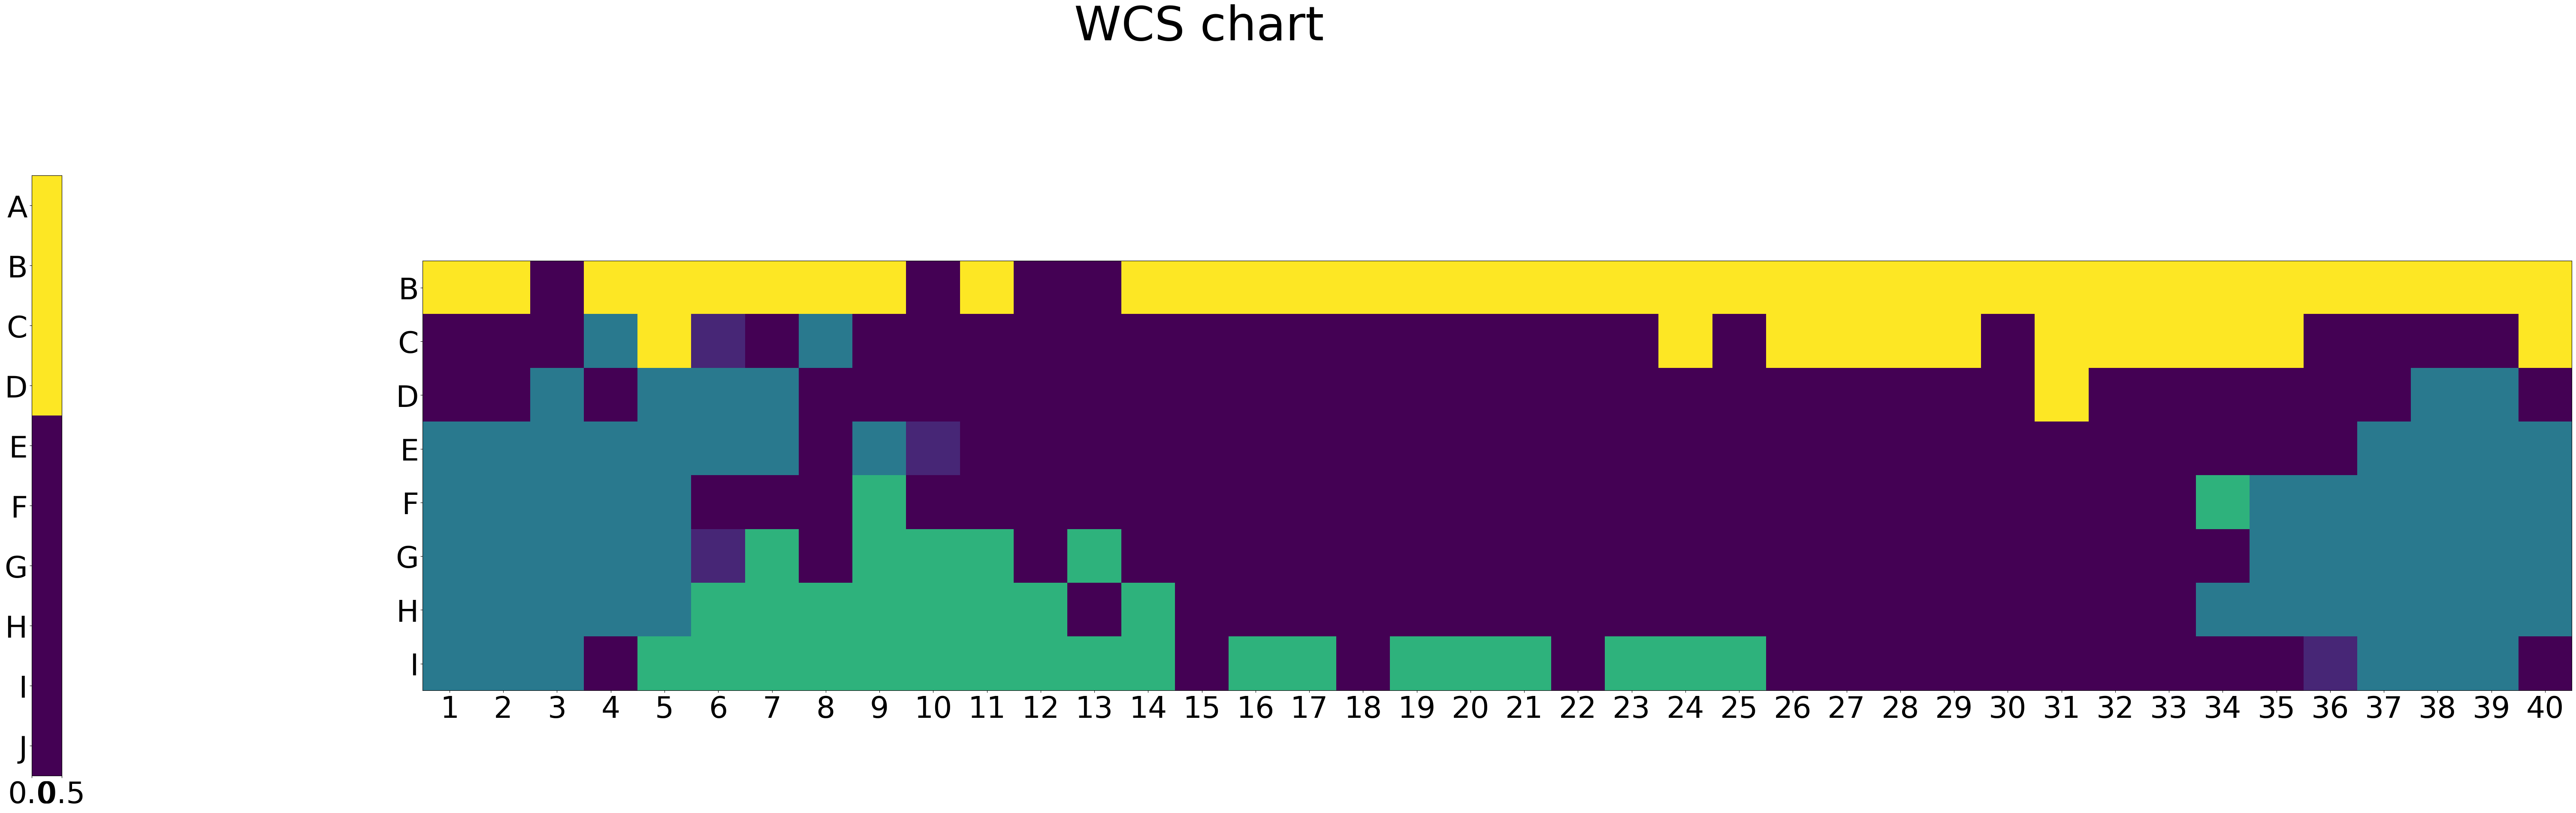

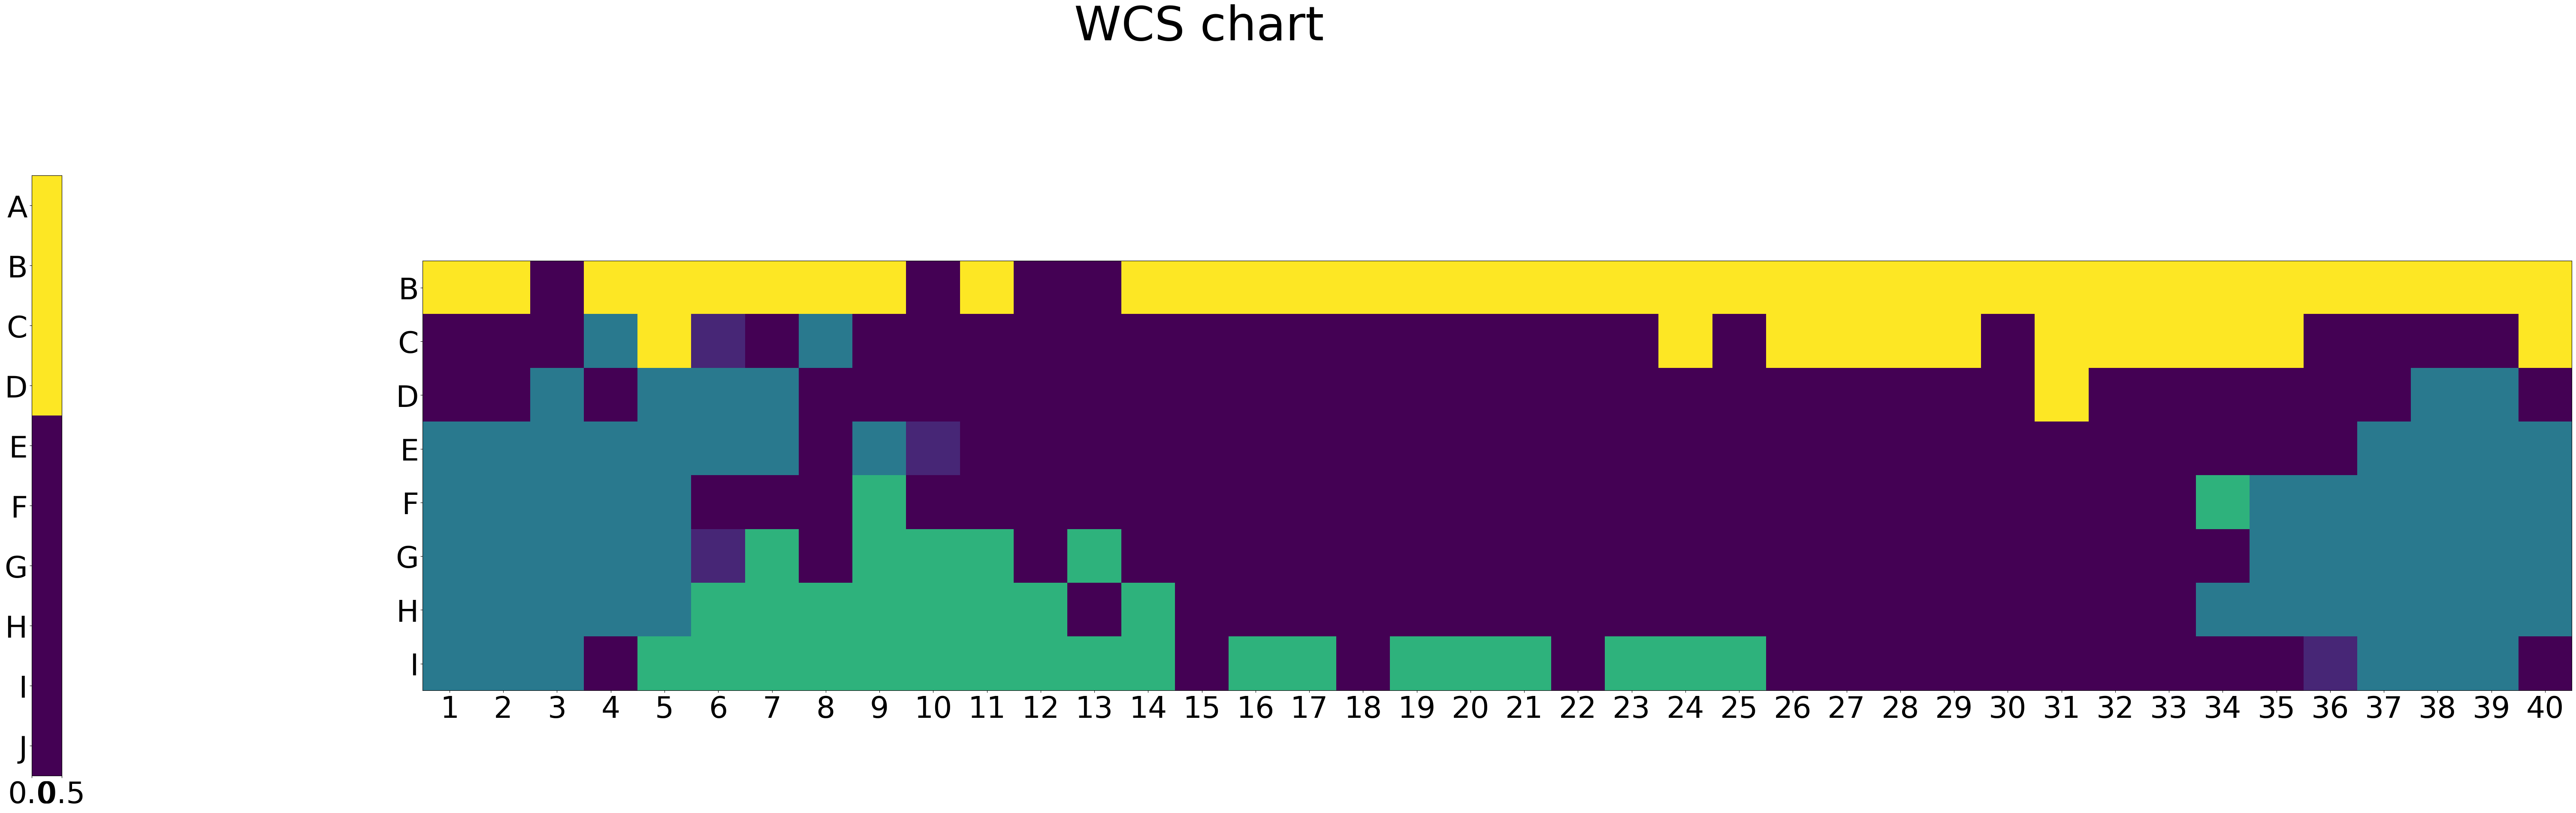

In [23]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

## Our Analysis

In [24]:
# for each speaker and language, map color term -> chip
# format: (language, speaker) -> color term -> chips (array of values)
# we'll use this dictionary for the prototype and exemplar calculations
speaker_terms = {}

for language in namingData:
    # speaker_terms[language] = {}
    for speaker in namingData[language]:
        # speaker_terms[language][speaker] = {}
        speaker_terms[(language, speaker)] = {}
        for chip in namingData[language][speaker]:
            term = namingData[language][speaker][chip]
            if term not in speaker_terms[(language, speaker)]:
                speaker_terms[(language, speaker)][term] = []
            speaker_terms[(language, speaker)][term].append(chip)

### Qualitative Analysis - Foci Contour Plots

#### Empirical Color Foci

Our first goal is to reproduce the following diagram from Abbott, Griffiths, & Regier (2016) showing the empirical color foci from the WCS dataset.

![image.png](images/empirical-contours.png)

This graph shows the color chips that were most commonly identified as the focus of some color term across all languages. The clustering of the contours suggests a set of universal basic colors at each of the peaks in the contour plot.

Part of our evaluation of the prototype and exemplar models will be a qualitative comparison of their predicted color foci plots to this empirical one.

In [25]:
wcs_chart_image = plt.imread('images/wcs-chart.png')

In [26]:
overallFociCount = {}
for language in fociData:
    speaker_data = fociData[language]
    for speaker in speaker_data:
        if (language, speaker) not in speaker_terms:
            # filter these because we won't be able to calculate prototype or exemplar similarity for them
            # this was done in the original paper as well
            continue
        colors = speaker_data[speaker]
        for color in colors:
            if color not in speaker_terms[(language, speaker)]:
                # more filtering for the same reason as above
                continue
            colorFoci = colors[color]
            for focus in colorFoci:
                focusIndex = coordIndex[focus.replace(':', '')]
                if focusIndex in overallFociCount:
                    overallFociCount[focusIndex] += 1
                else:
                    overallFociCount[focusIndex] = 1


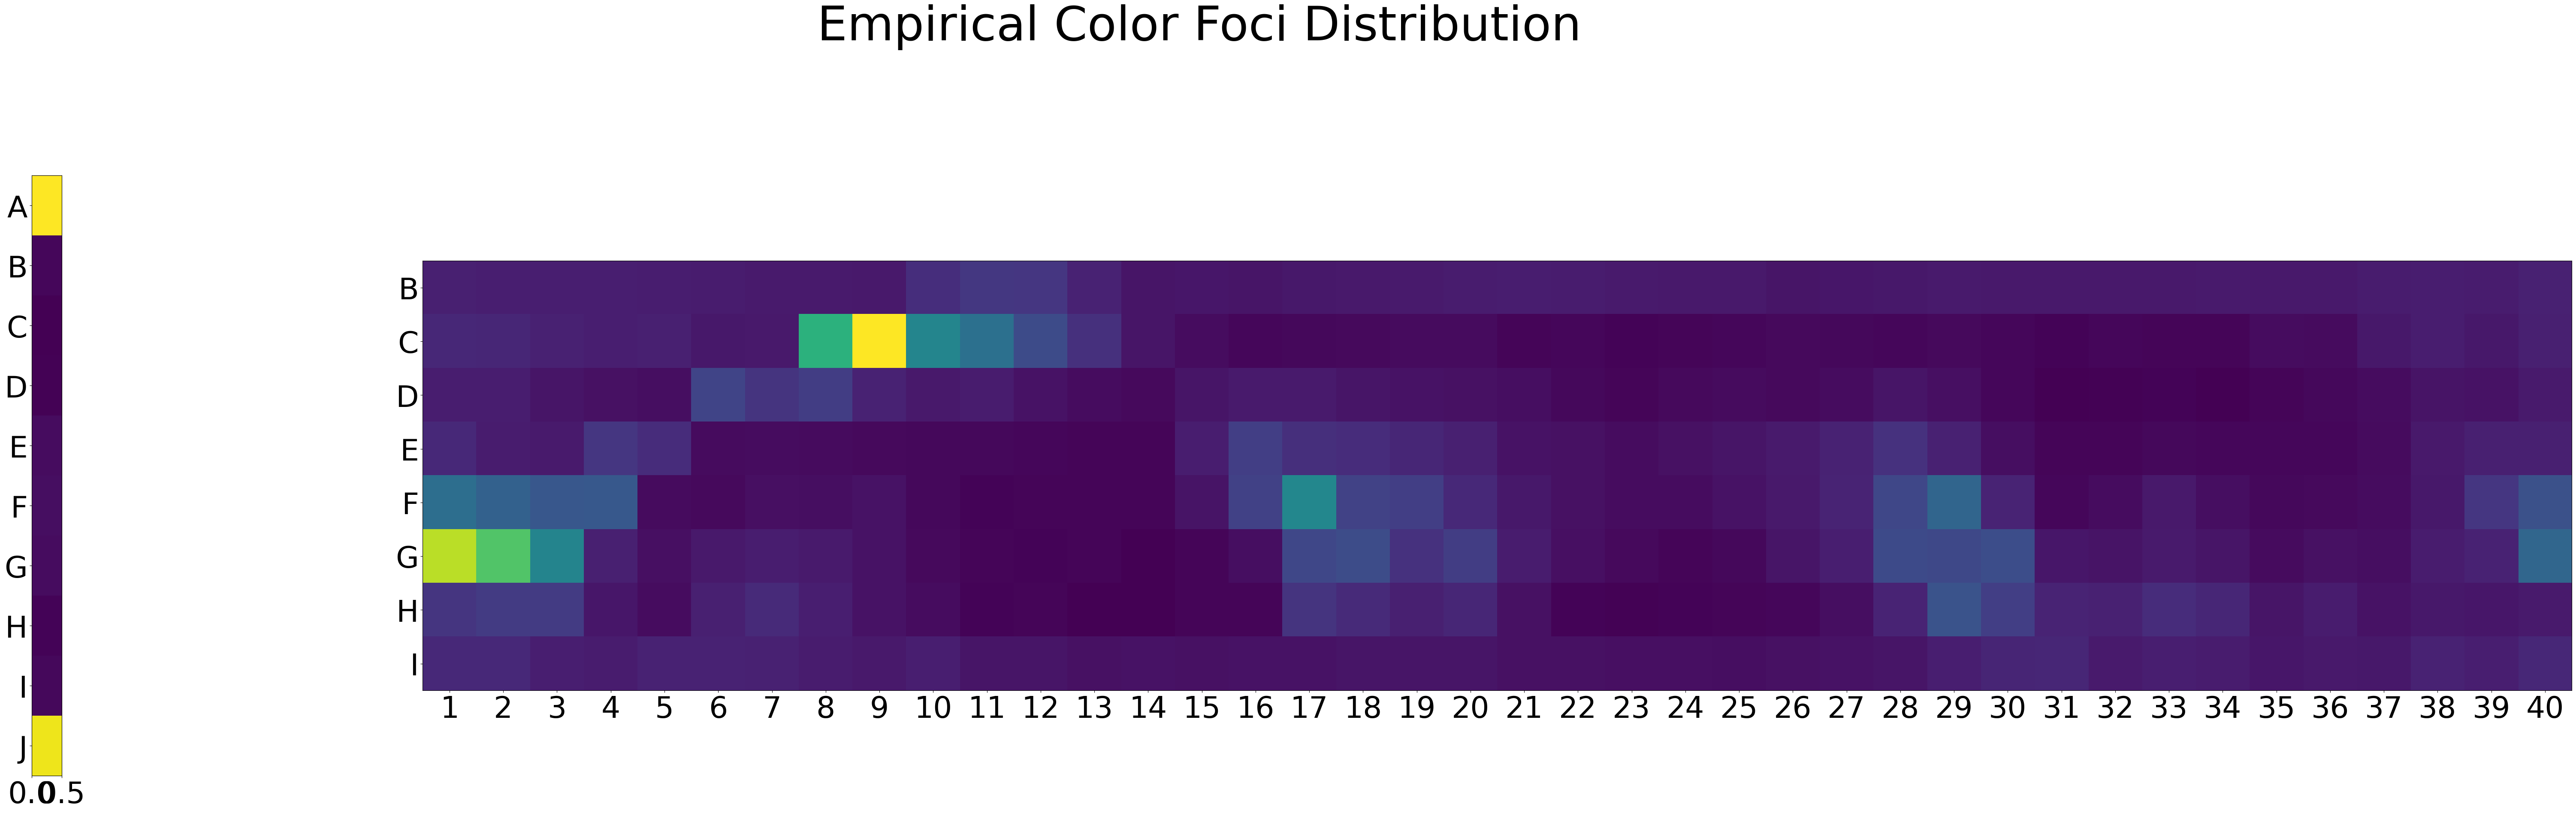

In [27]:
fig = plotValues(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

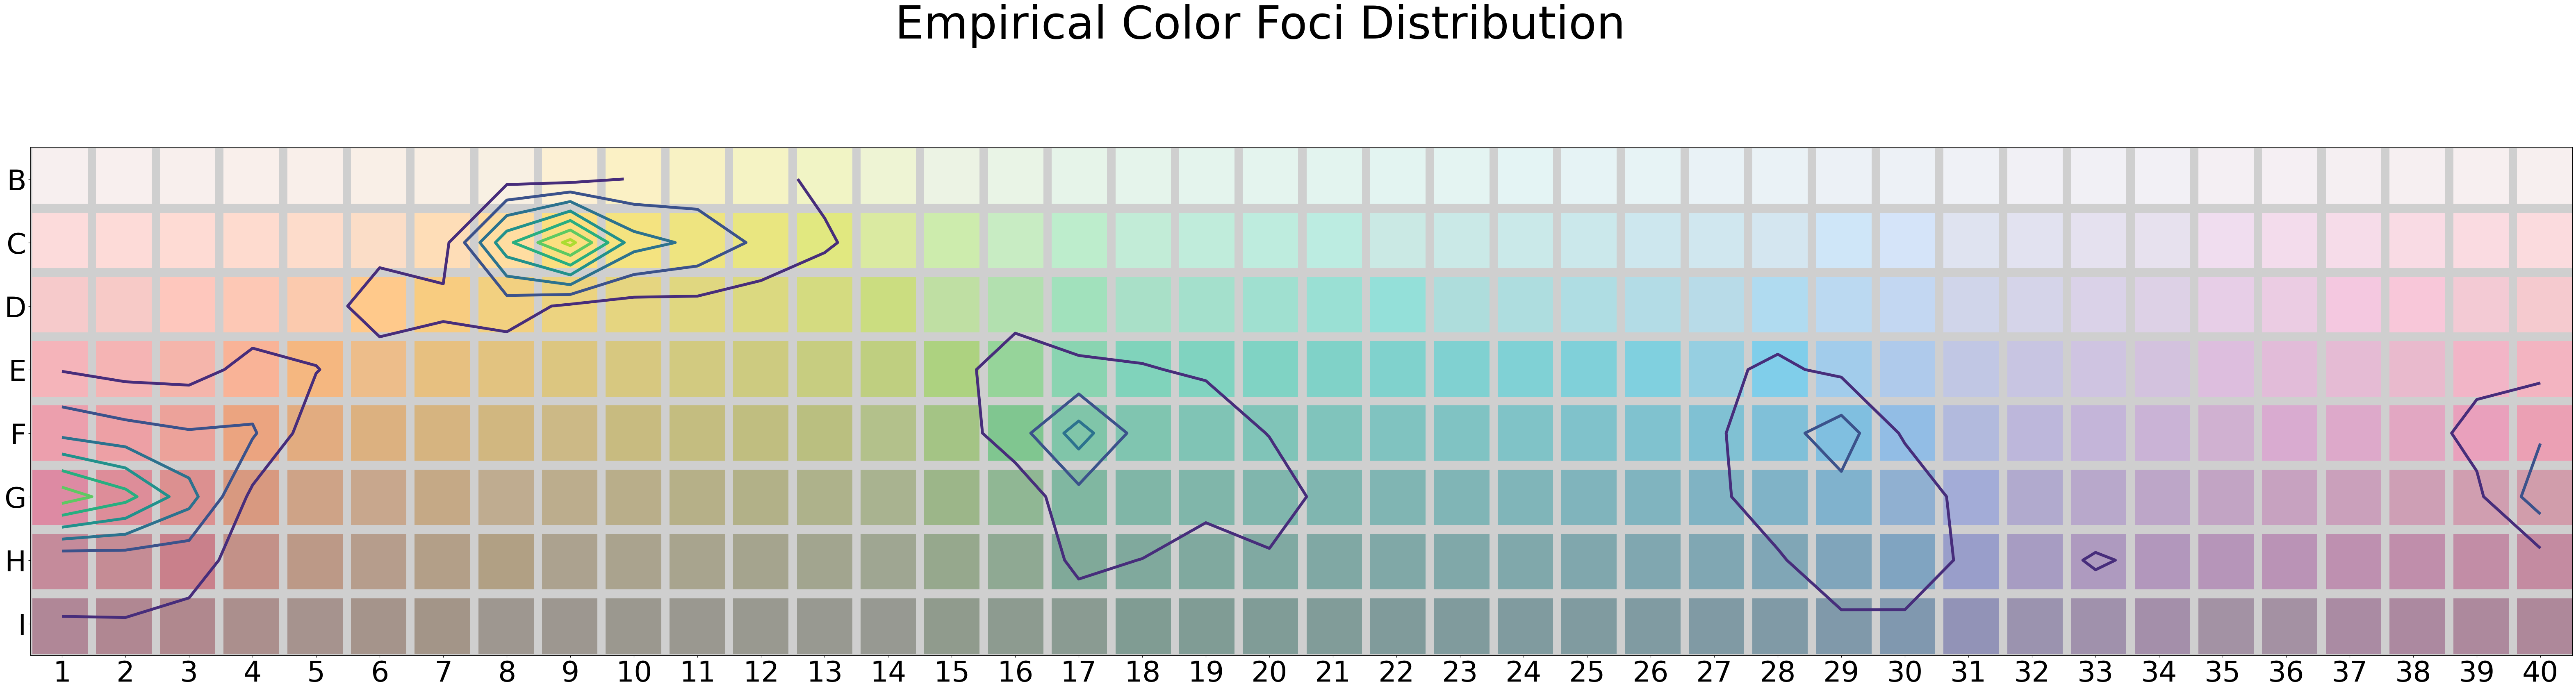

In [28]:
fig = plotValuesContour(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution', background=wcs_chart_image)

#### Prototype Model

![image.png](images/prototype-contours.png)

In [29]:
# now get the centroid of each color term for each language + speaker
# format: (language, speaker) -> color term -> CIELAB prototype coords
speaker_prototype = {}
for lang_speak in speaker_terms:
    speaker_prototype[lang_speak] = {}
    for color_term in speaker_terms[lang_speak]:
        chips = speaker_terms[lang_speak][color_term]
        # for each chip, get their cielab coordinates
        coords = np.array([tuple(map(float, cielabCoord[chip])) for chip in chips])
        # calculate centroid
        centroid = np.mean(coords, axis=0)
        speaker_prototype[lang_speak][color_term] = centroid

In [30]:
def compute_similarity(target, category_chips, c=0.001):
    # Vectorized computation of Euclidean distance between target and all CIELAB coordinates
    distances = np.linalg.norm(category_chips - target, axis=1)

    # Calculate the similarity scores
    similarities = np.exp(-c * distances**2)

    return similarities

cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])

In [31]:
def get_sorted_chips_prototype(prototype, chips, c=0.001):
    
    # compute similarity of prototype w/ all cielab coords to get coord closest to prototype
    similarities = compute_similarity(prototype, cielab_array)

    chip_num_with_sim = list(zip(cielabCoord.keys(), similarities))
    chip_num_with_sim.sort(key=lambda x: x[1], reverse=True)

    sorted_chips = [chip_num_with_sim[i][0] for i in range(len(chip_num_with_sim))]

    return sorted_chips

In [32]:
# now for each colour term, we'll try to predict foci coordinates (essentially recreating fociData)
prototype_predicted = {}
for language in fociData:
    for speaker in fociData[language]:
        if (language, speaker) not in speaker_prototype:
            continue
        for color_term in fociData[language][speaker]:
            if color_term not in speaker_prototype[(language, speaker)]:
                continue
            n = len(fociData[language][speaker][color_term])
            # predict foci coordinate -- compare speaker's prototype of this color term w/ CIELAB coords to get
            # the chip that's closest to the prototype
            prototype = np.array(speaker_prototype[(language, speaker)][color_term])

            top_n_indices = get_sorted_chips_prototype(prototype, cielab_array)[:n]
            set_top_n_indices = set(top_n_indices)

            # Update the predicted count for each of the top n chips
            for idx in set_top_n_indices:
                if idx not in prototype_predicted:
                    prototype_predicted[idx] = 0
                prototype_predicted[idx] += 1
            

In [33]:
print(len(prototype_predicted))
print(sum(overallFociCount.values()), sum(prototype_predicted.values())) # should be the same

330
29358 29358


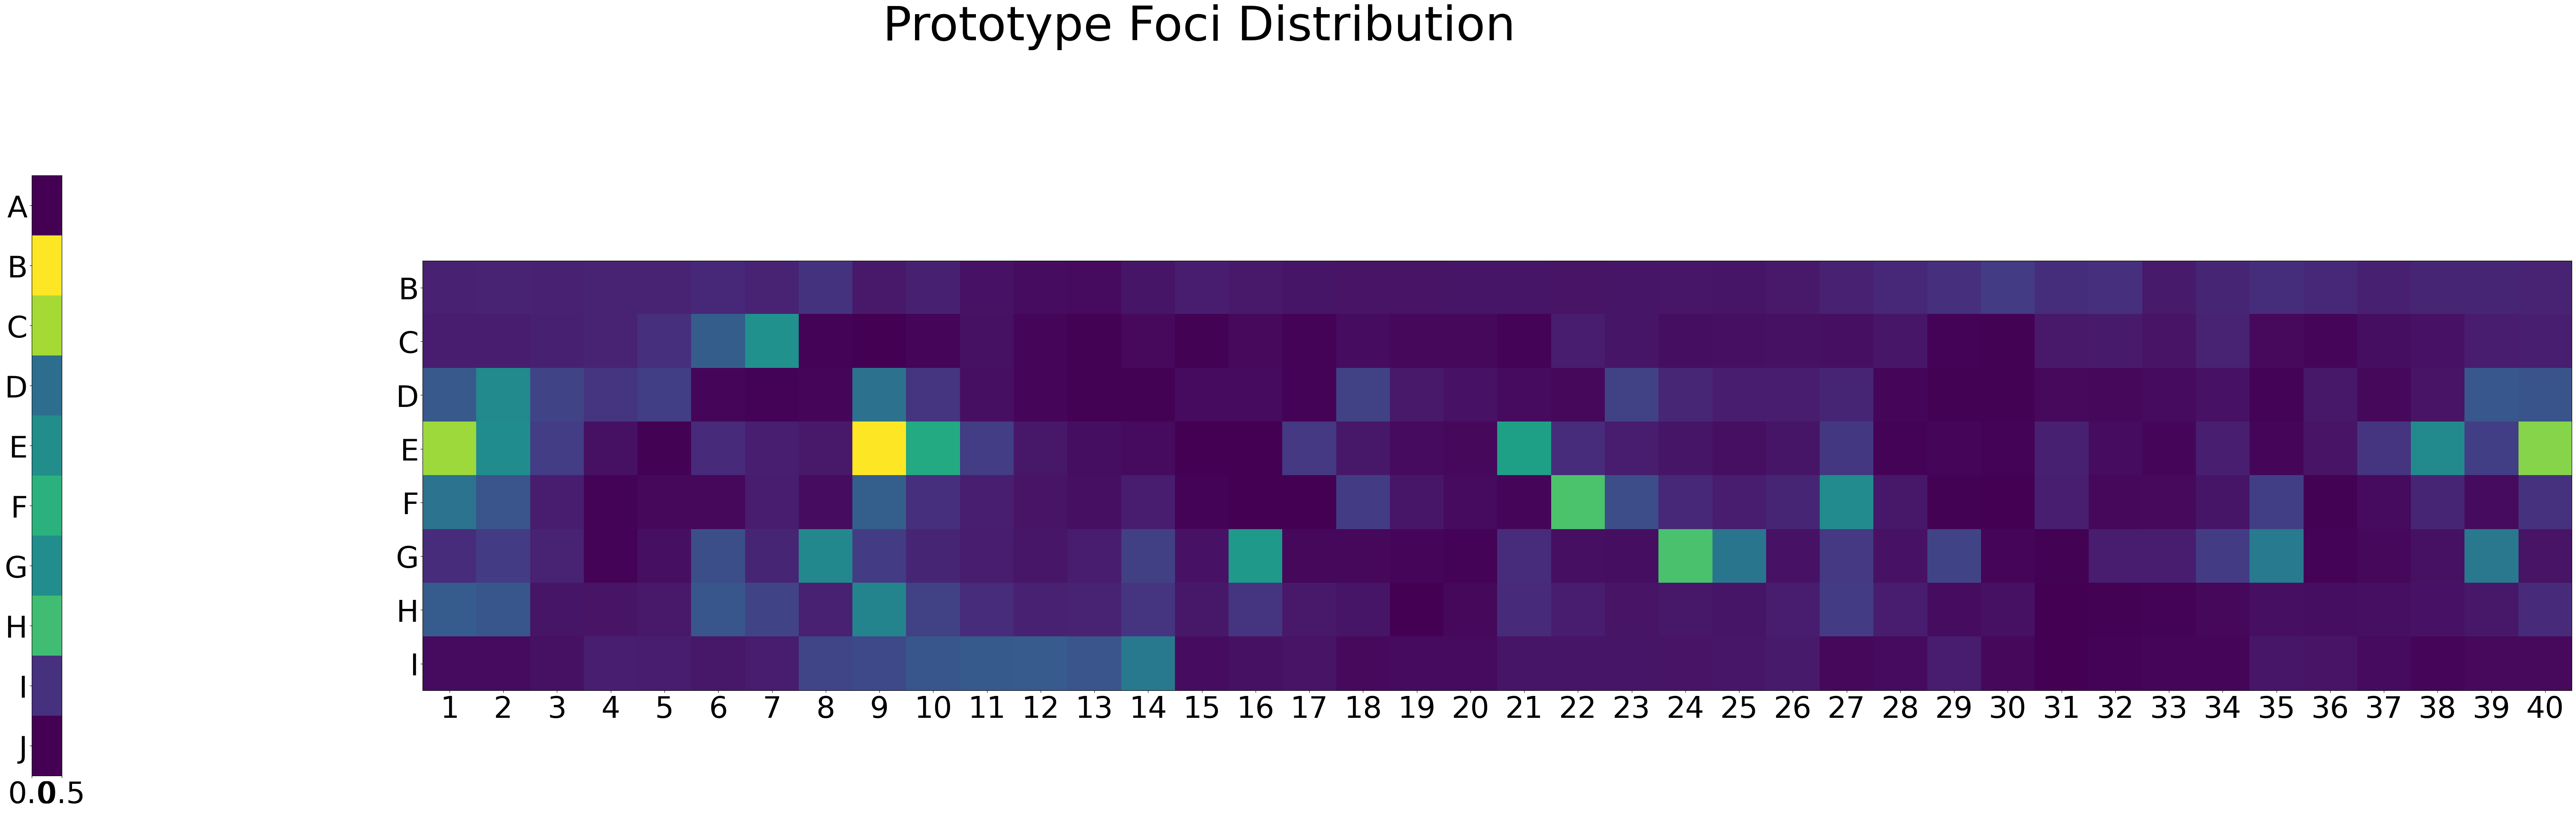

In [34]:
fig = plotValues(map_array_to(indexCoord, prototype_predicted), title='Prototype Foci Distribution')

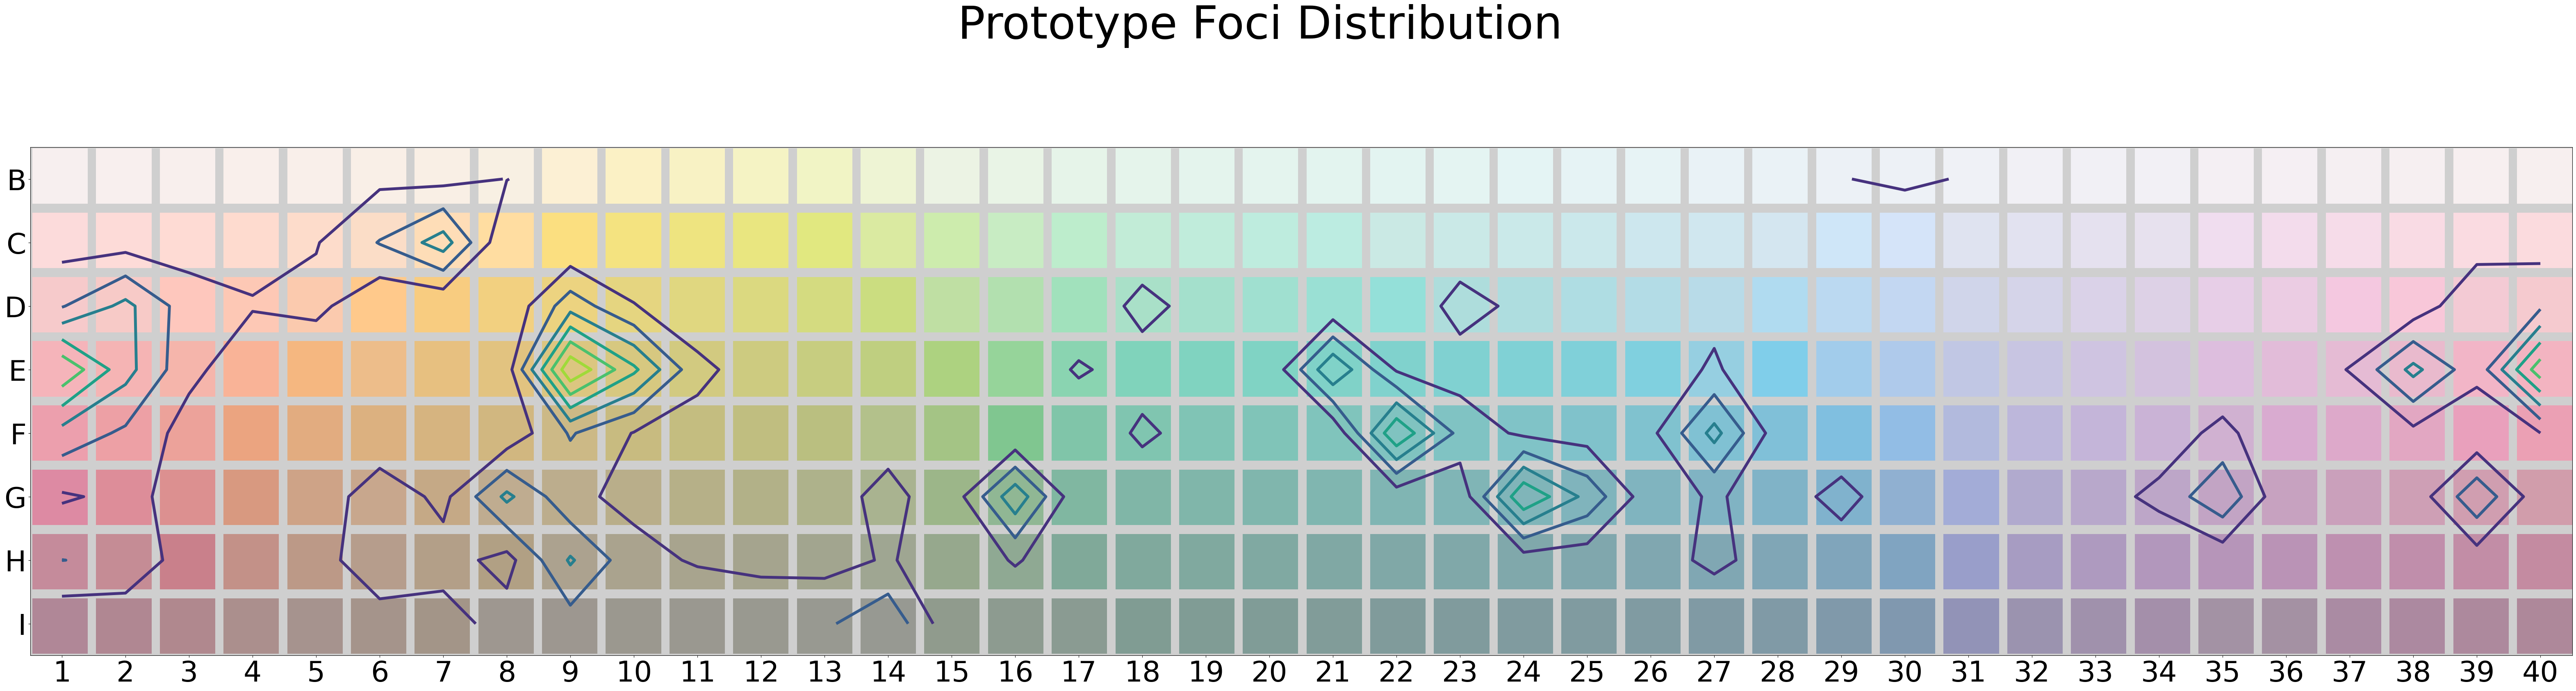

In [35]:
fig = plotValuesContour(map_array_to(indexCoord, prototype_predicted), title='Prototype Foci Distribution', background=wcs_chart_image)

#### Exemplar Model

![image.png](images/exemplar-contours.png)

In [36]:
def exemplar_scores(all_chips_cielab, category_chips_cielab):
    """Sort all chips based on their exemplar scores for the category."""

    scores = []
    for chip in all_chips_cielab:
        exemplar_score = np.sum(compute_similarity(chip, category_chips_cielab))
        scores.append(exemplar_score)
    
    return scores


In [37]:
def get_sorted_chips_exemplar(all_chips_cielab, category_chips_cielab):
    """Sort all chips based on their exemplar scores for the category."""

    scores = exemplar_scores(all_chips_cielab, category_chips_cielab)

    # Get indices of the top n most similar chips
    # more similar = larger score
    chip_num_with_score = list(zip(cielabCoord.keys(), scores))
    chip_num_with_score.sort(key=lambda x: x[1], reverse=True)

    return [chip_num_with_score[i][0] for i in range(len(chip_num_with_score))]

In [38]:
exemplar_predicted = {}
for language in fociData:
    language_data = fociData[language]
    for speaker in language_data:
        if (language, speaker) not in speaker_terms:
            continue
        speaker_data = language_data[speaker]
        for colour in speaker_data:
            fociInfo = speaker_data[colour]
            n = len(fociInfo)

            if colour not in speaker_terms[(language, speaker)]:
                continue
            category_chips = speaker_terms[(language,speaker)][colour]

            # Get the CIELAB coordinates for all chips in the category
            category_chips_cielab = np.array([tuple(map(float, cielabCoord[chip])) for chip in category_chips])
            
            top_n_indices = get_sorted_chips_exemplar(cielab_array, category_chips_cielab)[:n]
            set_top_n_indices = set(top_n_indices)

            # Update the predicted count for each of the top n chips
            for idx in set_top_n_indices:
                if idx not in exemplar_predicted:
                    exemplar_predicted[idx] = 0
                exemplar_predicted[idx] += 1

In [39]:
# sanity check to see if the same number of predictions are made as the number of foci in the empirical data
print(len(overallFociCount), len(exemplar_predicted)) # should be the same
print(sum(overallFociCount.values()), sum(exemplar_predicted.values())) # should be the same


330 330
29358 29358


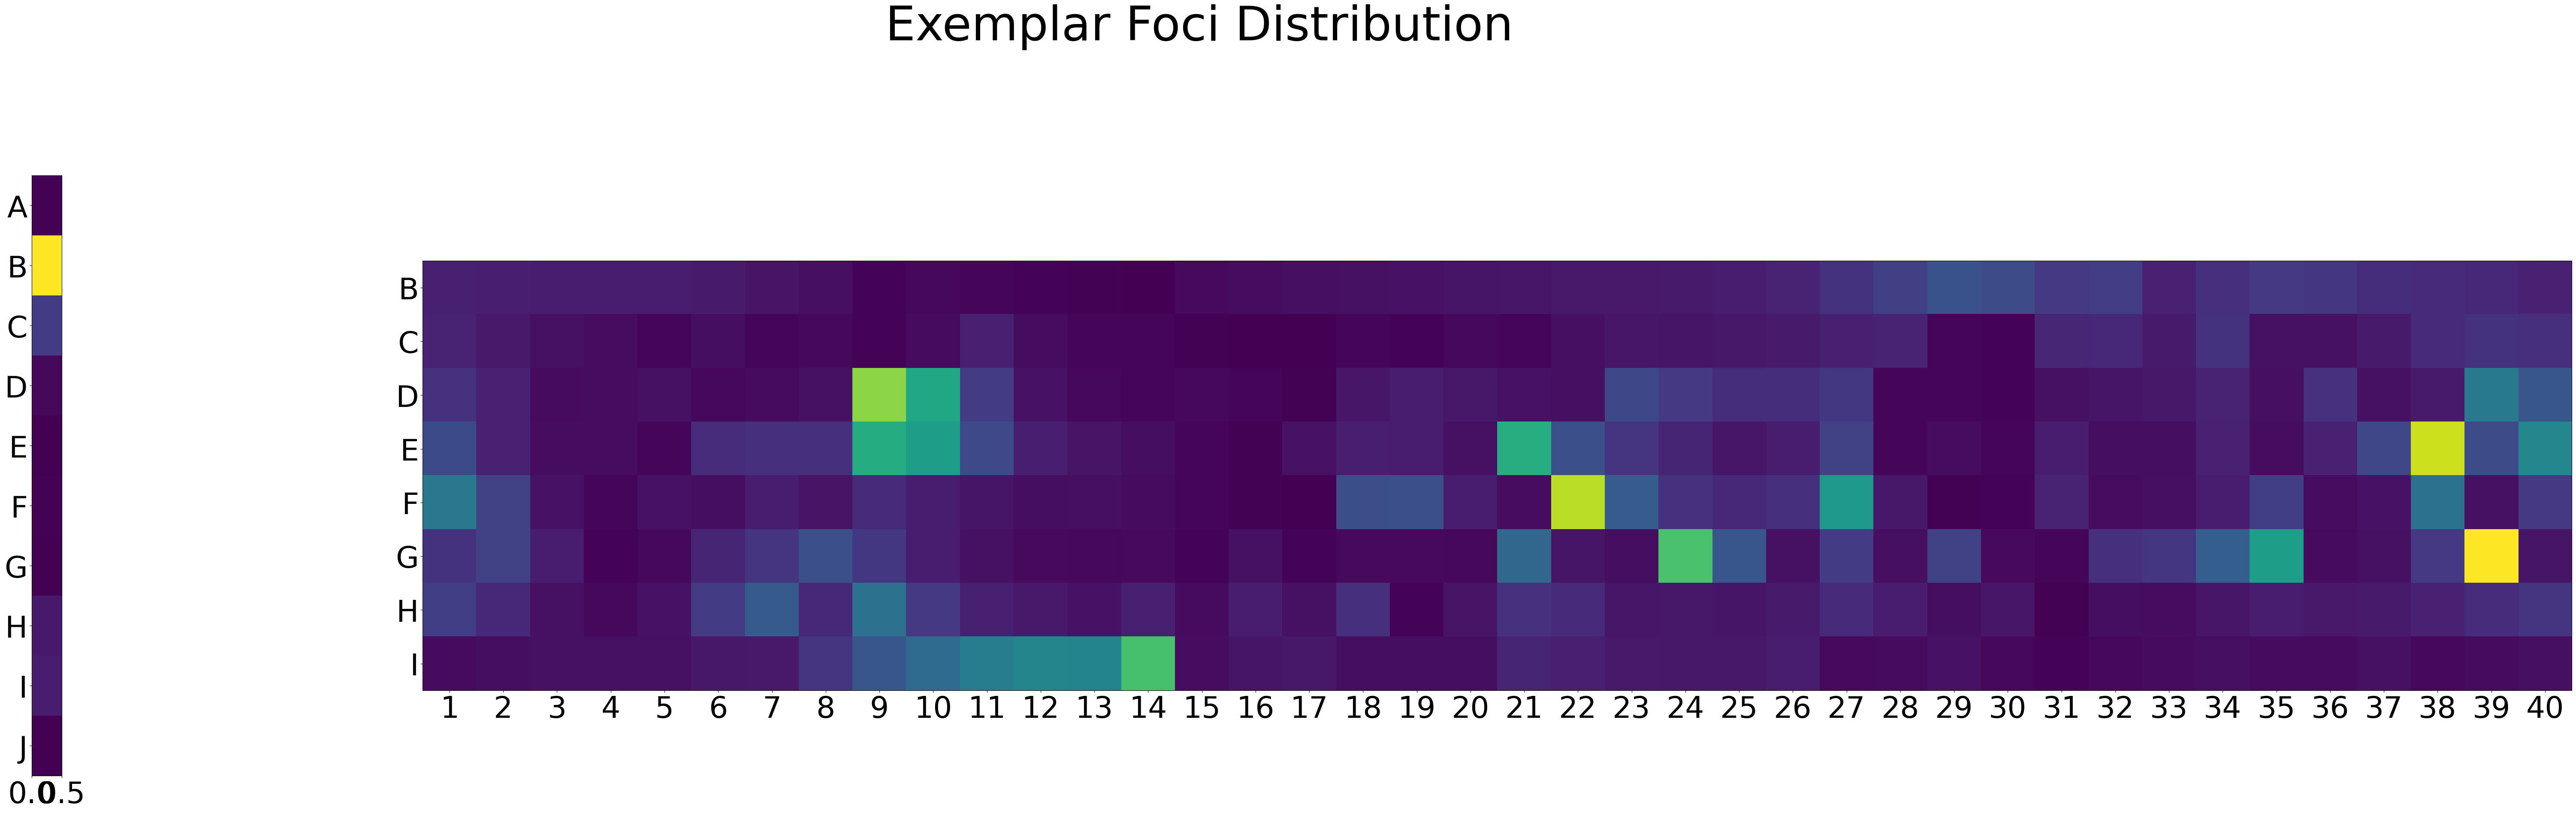

In [40]:
fig = plotValues(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution')

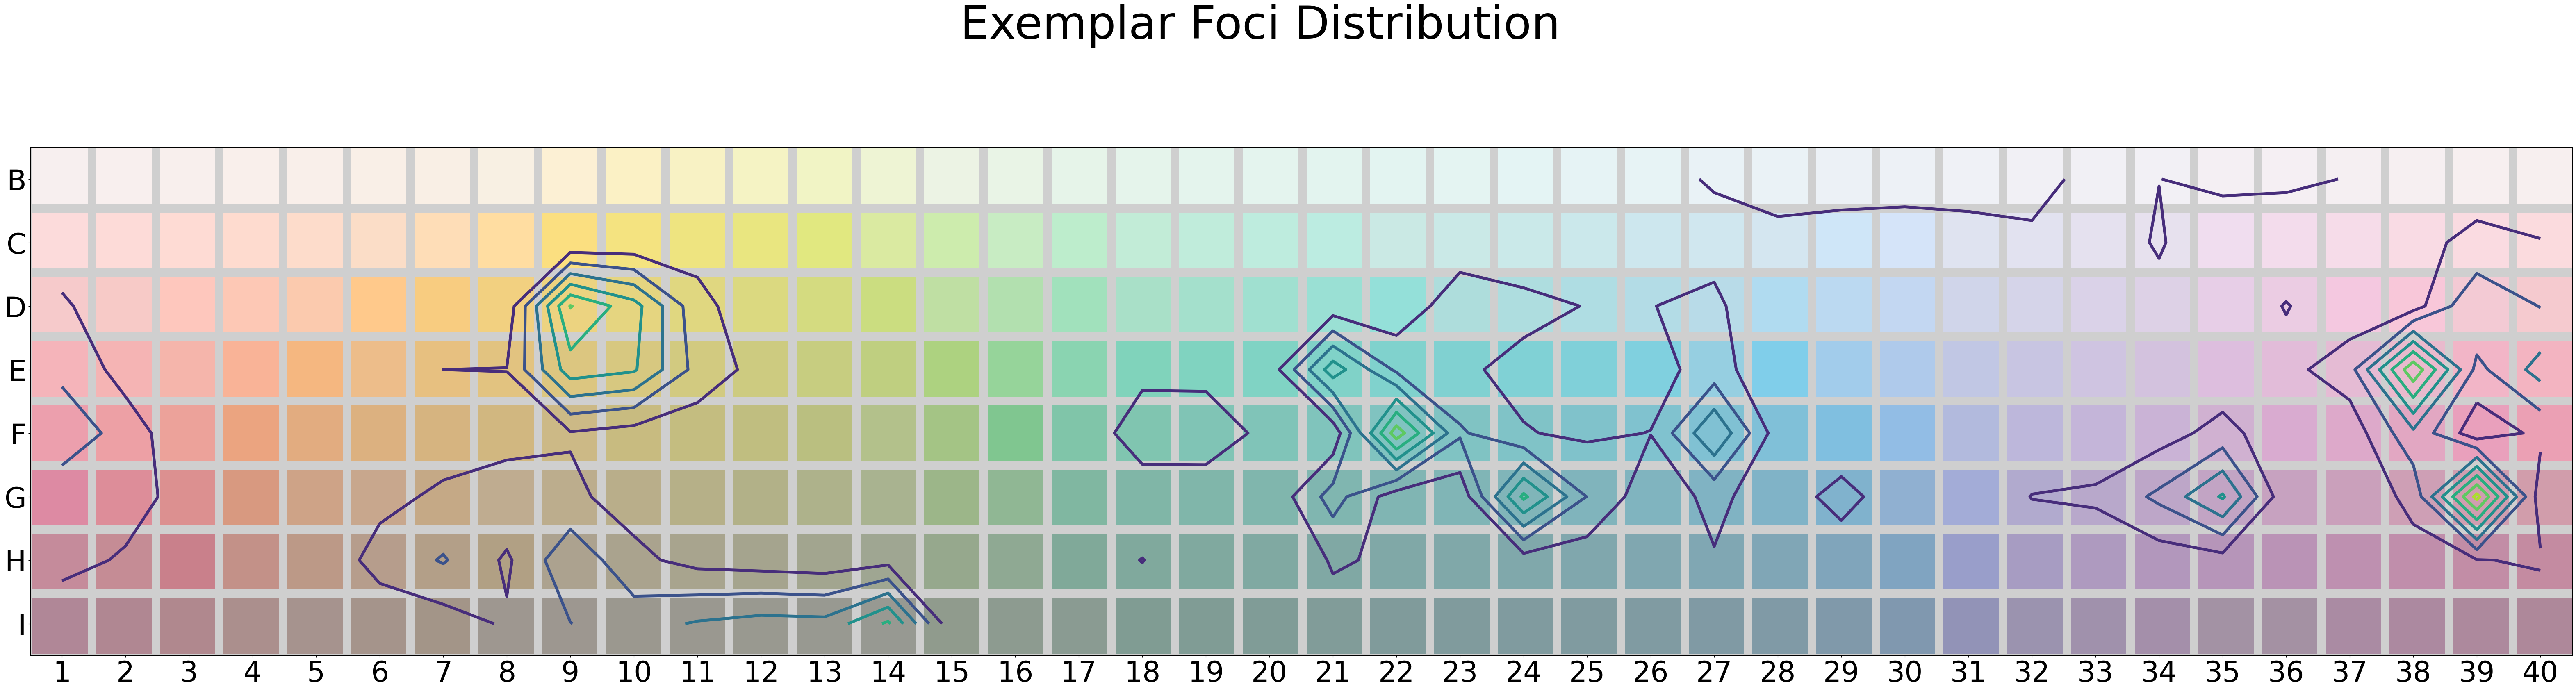

In [41]:
fig = plotValuesContour(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution', background=wcs_chart_image)

### Qualitative Analysis - Category Plots

#### Average Empirical Categories

In [69]:
color_terms_by_chip = {language: {chip: [] for chip in cielabCoord} for language in namingData}
for language in namingData:
    for speaker in namingData[language]:
        for chip in namingData[language][speaker]:
            color_terms_by_chip[language][chip].append(namingData[language][speaker][chip])
#color_terms_by_chip

In [71]:
modal_color_term_by_chip = {language: {chip: Counter(color_terms_by_chip[language][chip]).most_common(1)[0][0] for chip in color_terms_by_chip[language]} for language in color_terms_by_chip}
#modal_color_term_by_chip

In [73]:
color_term_to_num = {}
for language in namingData:
    color_term_to_num[language] = {}
    for term in modal_color_term_by_chip[language].values():
        if term not in color_term_to_num[language]:
            color_term_to_num[language][term] = len(color_term_to_num[language])

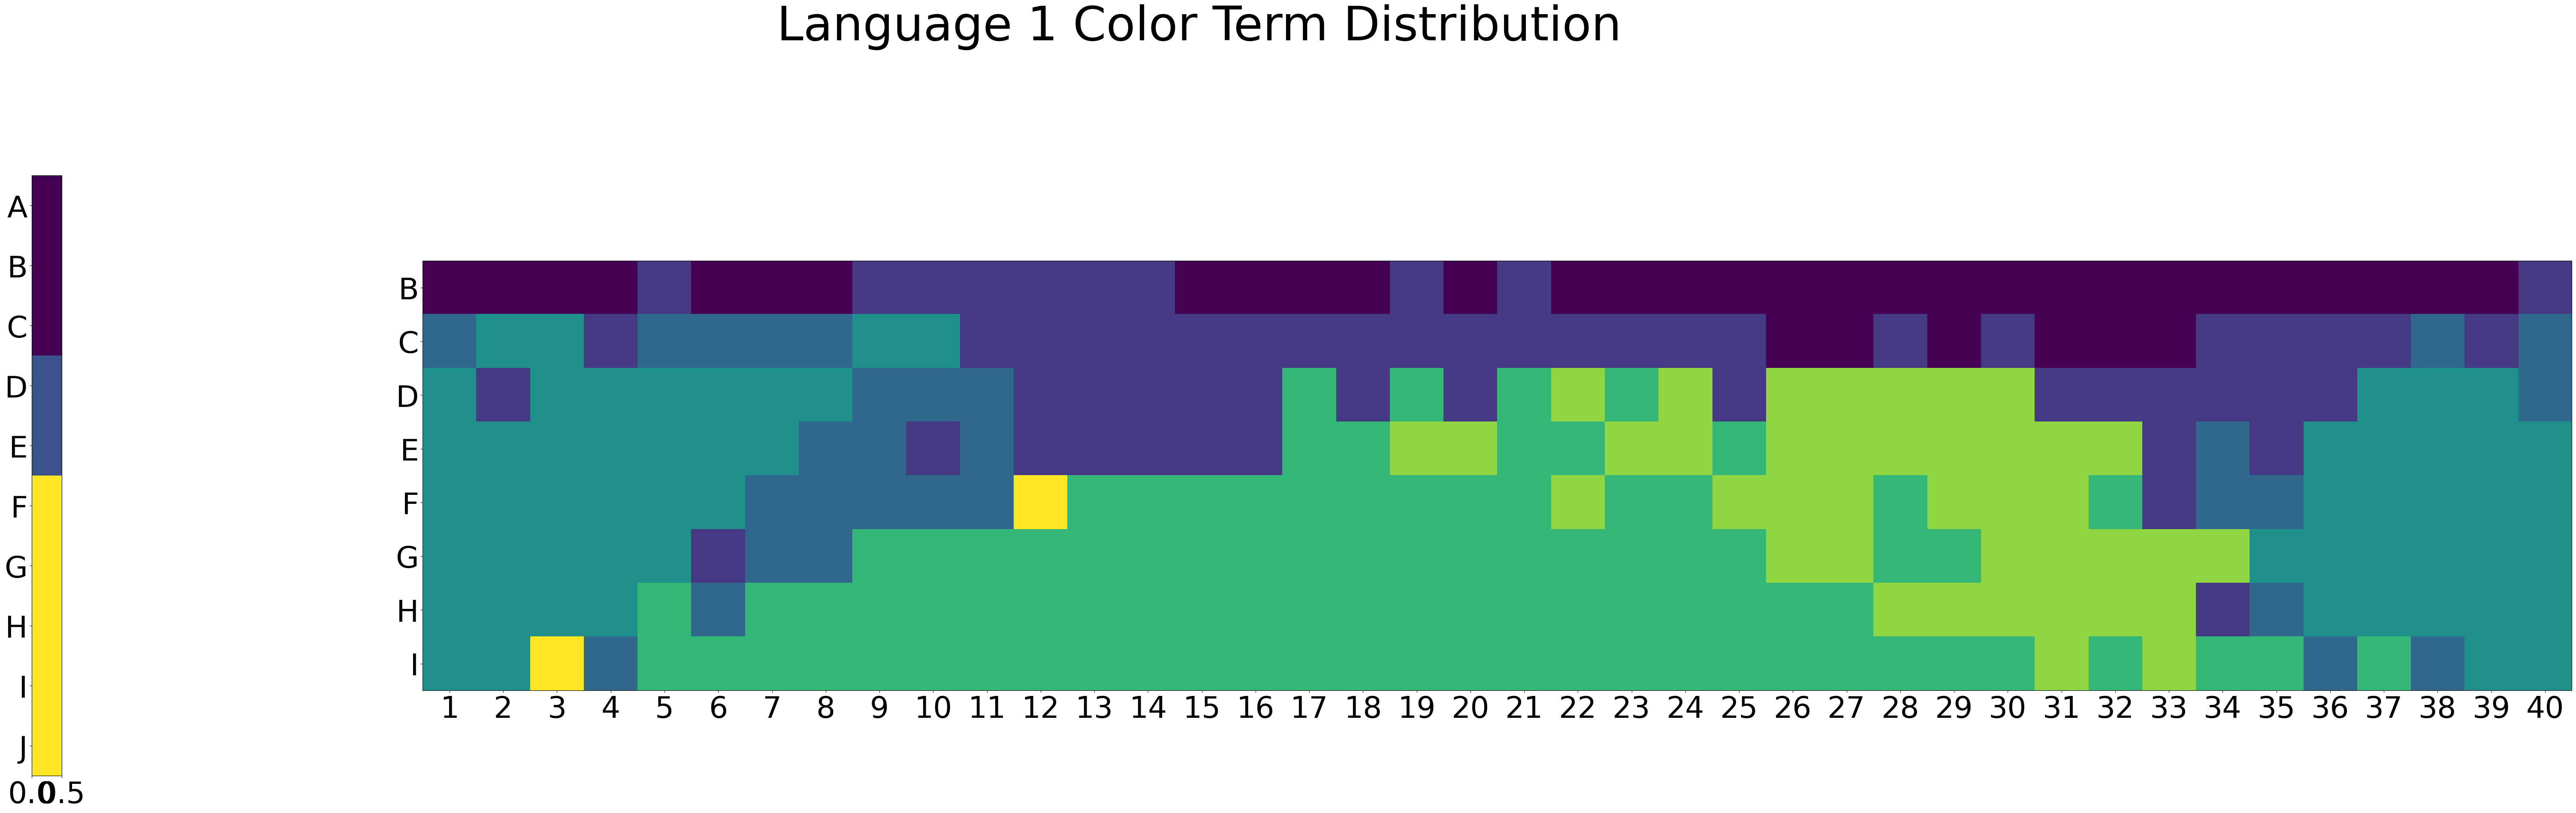

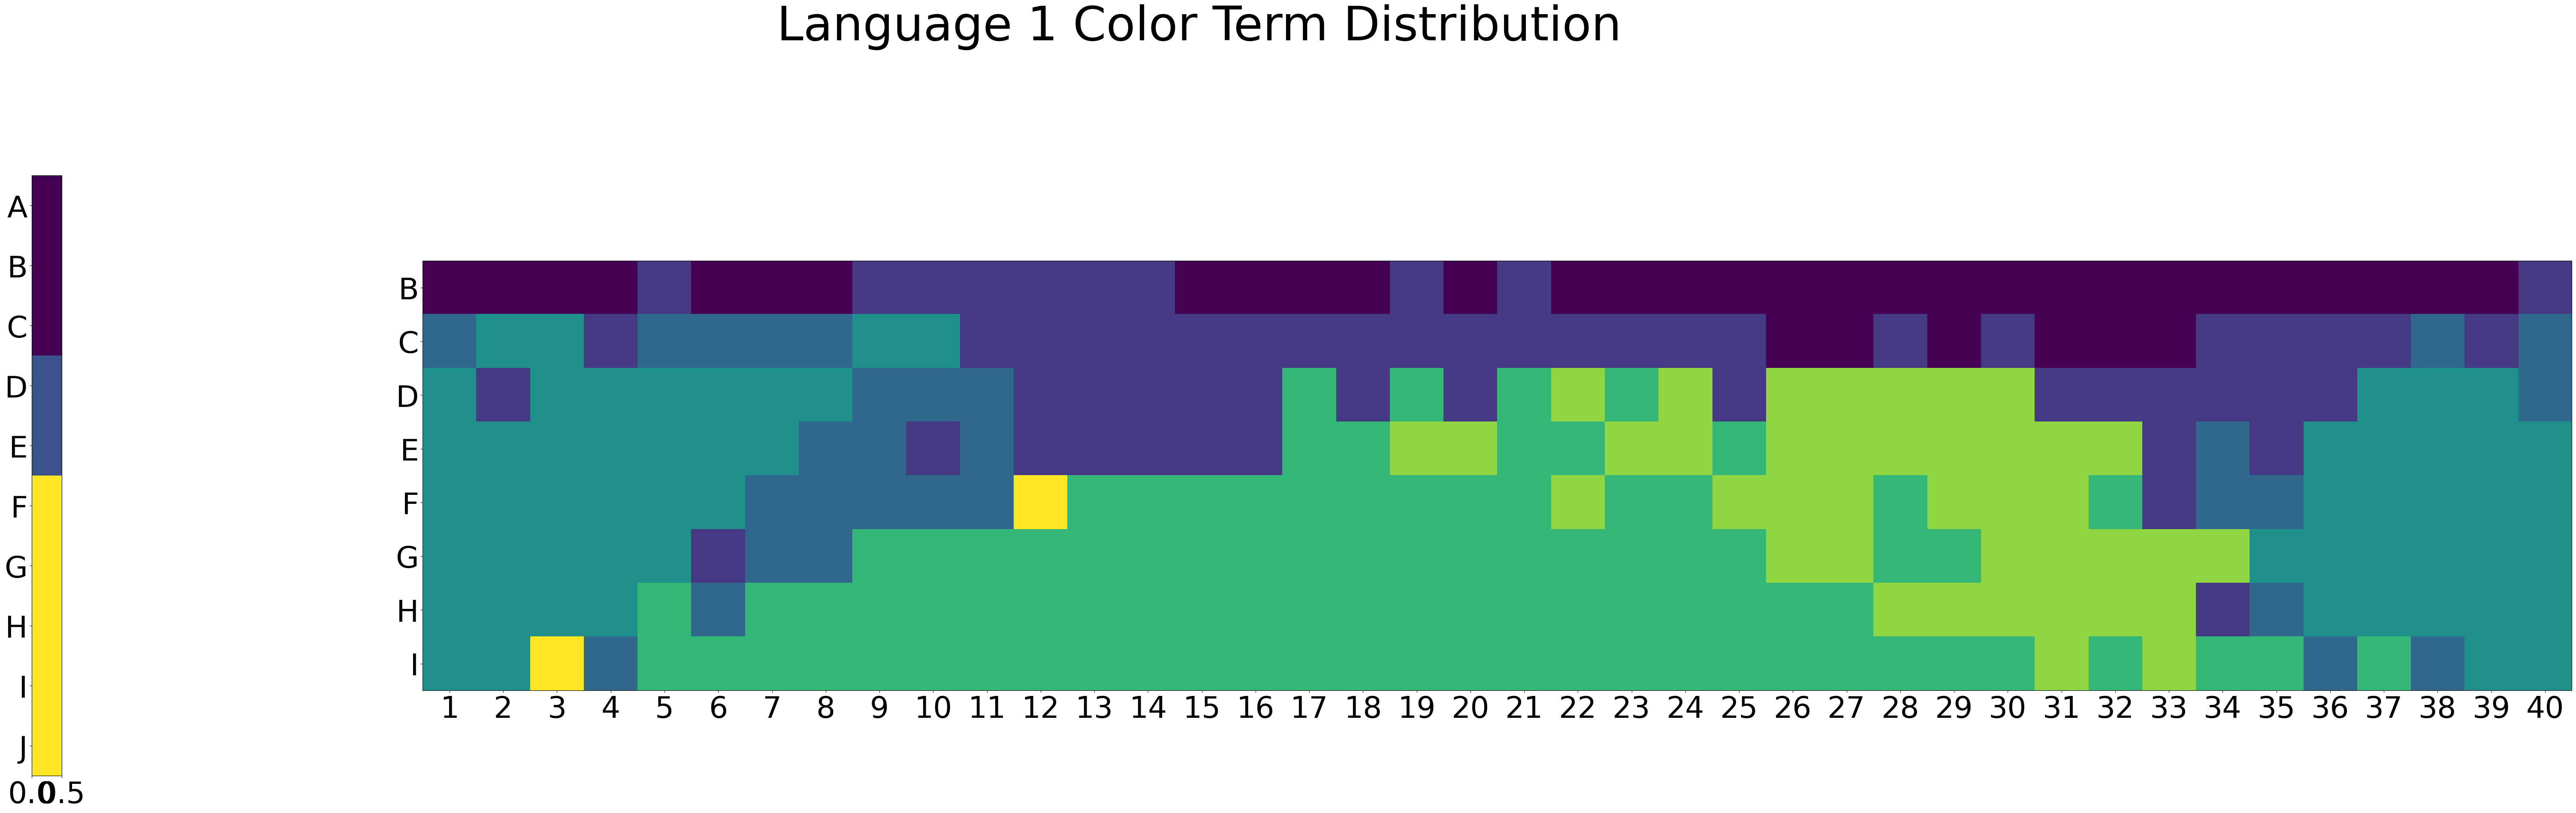

In [74]:
lang_1_terms = modal_color_term_by_chip[1]
lang_1_nums = color_term_to_num[1]

lang_1_chip_to_num = {chip: lang_1_nums[lang_1_terms[chip]] for chip in lang_1_terms}
plotValues(map_array_to(indexCoord, lang_1_chip_to_num), title='Language 1 Color Term Distribution')

### Quantitative Analysis

#### Average Model Categorization Accuracies by Speaker

In [44]:
prototype_accuracy = []
exemplar_accuracy = []
for language in namingData:
    for speaker in namingData[language]:
        prototype_correct = 0
        exemplar_correct = 0
        total_preds = 0
        if (language, speaker) not in speaker_prototype:
            continue
        for chip in namingData[language][speaker]:
            empirical_term = namingData[language][speaker][chip]
            if empirical_term not in speaker_prototype[(language, speaker)]:
                continue
            prototype_pred = None
            prototype_pred_sim = -1
            for term in speaker_prototype[(language, speaker)]:
                prototype = speaker_prototype[(language, speaker)][term]
                sim = compute_similarity(prototype, np.array([tuple(map(float, cielabCoord[chip]))]))[0]
                if sim > prototype_pred_sim:
                    prototype_pred = term
                    prototype_pred_sim = sim
            if prototype_pred == empirical_term:
                prototype_correct += 1
            
            exemplar_pred = None
            exemplar_pred_sim = -1
            for term in speaker_terms[(language, speaker)]:
                chips = speaker_terms[(language, speaker)][term]
                sim = np.sum(compute_similarity(np.array([tuple(map(float, cielabCoord[comp_chip])) for comp_chip in chips]), np.array([tuple(map(float, cielabCoord[chip]))]))[0])
                if sim > exemplar_pred_sim:
                    exemplar_pred = term
                    exemplar_pred_sim = sim
            if exemplar_pred == empirical_term:
                exemplar_correct += 1

            total_preds += 1

        prototype_accuracy.append(prototype_correct / total_preds)
        exemplar_accuracy.append(exemplar_correct / total_preds)

print("Prototype accuracy: ", np.mean(prototype_accuracy))
print("Exemplar accuracy: ", np.mean(exemplar_accuracy))

Prototype accuracy:  0.6069595032897785
Exemplar accuracy:  0.3985346585117227


#### QF distance

In [45]:
def create_histogram(distribution, num_chips=330):
    histogram = np.zeros(num_chips)
    for chip_index in sorted(distribution.keys()):
        histogram[int(chip_index) - 1] = distribution[int(chip_index)]  # Assuming chip_index starts from 1
    
    return histogram

def normalize_histogram(h):
    # normalization?
    normalized = h
    # max = np.max(normalized)
    # if max > 0:
    #     normalized = normalized / max

    total = np.sum(normalized)
    #print(total)
    if total > 0:
        normalized = normalized / total

    return normalized

# Assuming we have 330 chips
hist_prototype = create_histogram(prototype_predicted, 330)
hist_wcs_focus = create_histogram(overallFociCount, 330)
hist_exemplar = create_histogram(exemplar_predicted, 330)

normalized_hist_prototype = normalize_histogram(hist_prototype)
normalized_hist_wcs_focus = normalize_histogram(hist_wcs_focus)
normalized_hist_exemplar = normalize_histogram(hist_exemplar)
#print(hist_prototype)

# print([int(x) for x in hist_prototype].sort() == list(prototype_predicted.values()).sort())
# print(exemplar_predicted.keys())

In [46]:
sum(normalized_hist_exemplar), sum(normalized_hist_prototype), sum(normalized_hist_wcs_focus) # check that we normalized correctly, should be around 1

(0.9999999999999987, 0.9999999999999991, 0.9999999999999997)

In [47]:
print(normalized_hist_prototype.max(), normalized_hist_wcs_focus.max(), normalized_hist_exemplar.max())

0.03709380748007357 0.08045507187138087 0.06243613325158389


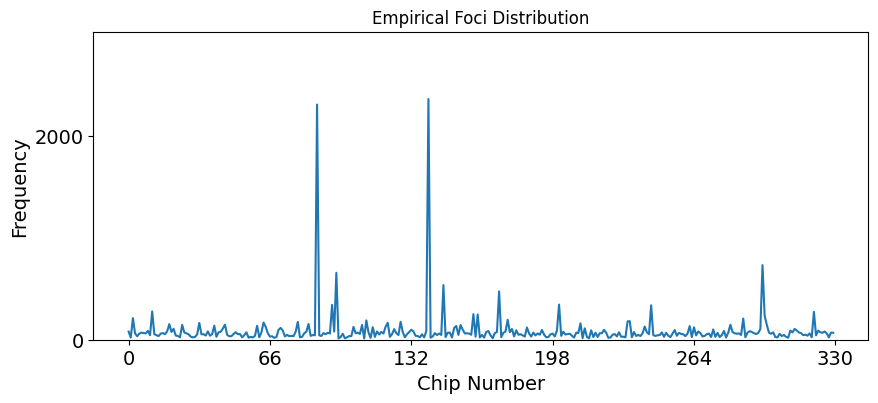

In [48]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_wcs_focus)
plt.ylim(0, max(hist_prototype + hist_wcs_focus + hist_exemplar))
plt.title('Empirical Foci Distribution')
plt.yticks(fontsize=14)
plt.xticks(np.linspace(0, 330, 6), fontsize=14)
plt.xlabel('Chip Number', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

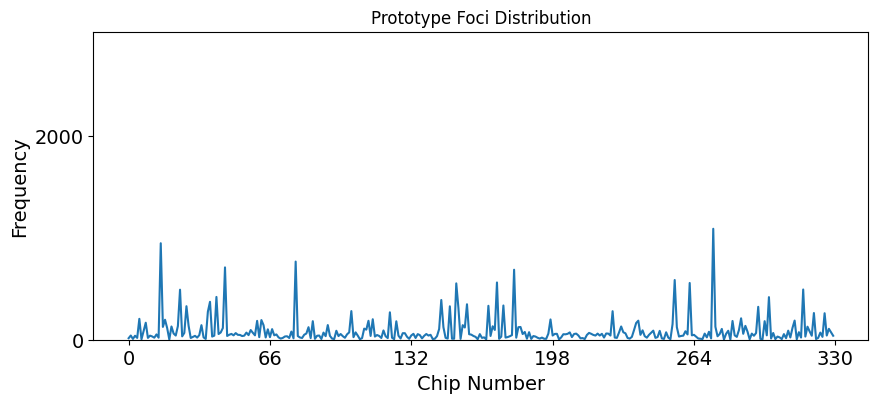

In [49]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_prototype)
plt.ylim(0, max(hist_prototype + hist_wcs_focus + hist_exemplar))
plt.title('Prototype Foci Distribution')
plt.yticks(fontsize=14)
plt.xticks(np.linspace(0, 330, 6), fontsize=14)
plt.xlabel('Chip Number', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

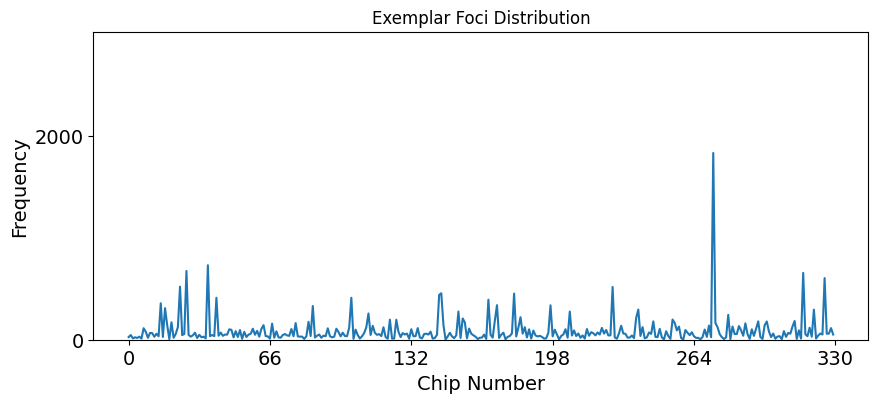

In [50]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_exemplar)
plt.ylim(0, max(hist_prototype + hist_wcs_focus + hist_exemplar))
plt.title('Exemplar Foci Distribution')
plt.yticks(fontsize=14)
plt.xticks(np.linspace(0, 330, 6), fontsize=14)
plt.xlabel('Chip Number', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [65]:
def qf_distance(H1, H2, M):
    diff = H1 - H2
    d = np.dot(M, diff)
    return np.sqrt(np.dot((H1 - H2).T, d))

In [101]:
def calculate_similarity_matrix(cielab_coords, c=0.001):
    num_chips = len(cielab_coords)
    M = np.zeros((num_chips, num_chips))

    for i in range(num_chips):
        for j in range(num_chips):
            # Calculate Euclidean distance between chip i and chip j
            distance = np.linalg.norm(cielab_coords[i] - cielab_coords[j])
            # Calculate similarity based on the distance
            M[i, j] = np.exp(-c * distance**2)
    # normalize
    max_value = np.max(M)
    if max_value > 0:
        M = M / max_value

    return M

In [102]:
cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])
print(cielab_array.shape)

M = calculate_similarity_matrix(cielab_array)
print(M.max(), M.min()) # should be around 1 and 0

(330, 3)
1.0 6.249905908047552e-13


In [54]:
M.shape # should be 330 x 330

(330, 330)

In [55]:
all(M[i, i] == 1 for i in range(330)) # should be true

True

In [56]:
all(0 <= x <= 1 for x in M.flatten())

True

In [66]:
qf_prototype = qf_distance(normalized_hist_prototype, normalized_hist_wcs_focus, M)
qf_prototype

0.13964737934884275

In [68]:
qf_exemplar = qf_distance(normalized_hist_exemplar, normalized_hist_wcs_focus, M)
qf_exemplar

0.155491751718603

#### Euclidean Distance Between Histograms

In [90]:
print("Euclidean distance between prototype and empirical histogram: ", np.linalg.norm(hist_prototype - hist_wcs_focus))
print("Euclidean distance between exemplar and empirical histogram: ", np.linalg.norm(hist_exemplar - hist_wcs_focus))

Euclidean distance between prototype and empirical histogram:  4336.453850786377
Euclidean distance between exemplar and empirical histogram:  4433.5182417578935


#### Earth Mover's Distance

In [103]:
def calculate_distance_matrix(cielab_coords):
    num_chips = len(cielab_coords)
    M = np.zeros((num_chips, num_chips))

    for i in range(num_chips):
        for j in range(num_chips):
            # Calculate Euclidean distance between chip i and chip j
            distance = np.linalg.norm(cielab_coords[i] - cielab_coords[j])
            M[i, j] = distance

    return M

M_distance = calculate_distance_matrix(cielab_array)

In [104]:
from pyemd import emd

print("Earth mover distance between empirical and prototype:", emd(hist_prototype, hist_wcs_focus, M_distance))
print("Earth mover distance between empirical and exemplar:", emd(hist_exemplar, hist_wcs_focus, M_distance))

Earth mover distance between empirical and prototype: 426361.4311334971
Earth mover distance between empirical and exemplar: 479254.74672870134


#### K-L Divergence

In [63]:
def k_l_divergence(P, Q):
    """Calculate the Kullback-Leibler divergence between two distributions."""
    return np.sum(P * np.log(P / Q))

print("K-L divergence between empirical and prototype:", k_l_divergence(normalized_hist_wcs_focus, normalized_hist_prototype))
print("K-L divergence between empirical and exemplar:", k_l_divergence(normalized_hist_wcs_focus, normalized_hist_exemplar))

K-L divergence between empirical and prototype: 1.4534075541418636
K-L divergence between empirical and exemplar: 1.336861396871643


#### Rank

Here, we quantitatively evaluate each model based on where (on average) the true empirical foci appear in the rankings of all 330 chips returned by each model for each language-speaker-color term combo. If the model is optimal, the empirically listed foci should appear close to the top of the ranking of the chips that's returned by the model.

In [62]:
empirical_ranks_in_prototype = []
empirical_ranks_in_exemplar = []

for language in fociData:
    speaker_data = fociData[language]
    for speaker in speaker_data:
        if (language, speaker) not in speaker_terms:
            continue
        for color_term in speaker_data[speaker]:
            if color_term not in speaker_terms[(language, speaker)]:
                continue
            
            prototype = np.array(speaker_prototype[(language, speaker)][color_term])
            prototype_ranking = get_sorted_chips_prototype(prototype, cielab_array)

            category_chips = speaker_terms[(language,speaker)][color_term]
            category_chips_cielab = np.array([tuple(map(float, cielabCoord[chip])) for chip in category_chips])
            exemplar_ranking = get_sorted_chips_exemplar(cielab_array, category_chips_cielab)

            for foci in speaker_data[speaker][color_term]:
                chip = coordIndex[foci.replace(':', '')]
                empirical_ranks_in_prototype.append(prototype_ranking.index(chip) + 1)
                empirical_ranks_in_exemplar.append(exemplar_ranking.index(chip) + 1)

avg_empirical_rank_in_prototype = np.mean(empirical_ranks_in_prototype)
avg_empirical_rank_in_exemplar = np.mean(empirical_ranks_in_exemplar)

print(f"Average Rank Position in Prototype Model: {avg_empirical_rank_in_prototype}")
print(f"Average Rank Position in Exemplar Model: {avg_empirical_rank_in_exemplar}")

Average Rank Position in Prototype Model: 52.40448940663533
Average Rank Position in Exemplar Model: 44.418931807343824
